# 竞赛————脱发vip客户组

In [53]:
import pymssql
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine

# 数据库连接
server = '202.117.45.203:5018'
user = 'sntm'
password = 'XJTUbid$2022'
db = 'RenCompetition'
connect = pymssql.connect(server, user, password, db, charset='GB18030') #解决乱码问题
if connect:
    print("连接成功！")
engine = create_engine('mssql+pymssql://' + user + ':' + password + '@' + server + '/' + db)
    
cursor = connect.cursor()   #创建一个游标对象,python里的sql语句都要通过cursor来执行


连接成功！


In [ ]:
# 读取关系数据到dataframe
sql = "select count(1) from Relationships;"
cursor.execute(sql)   #执行sql语句
row = cursor.fetchone()  #读取查询结果,
print("Relationships表的数据共%s行" % (row[0]))   #输出结果

sql = "select count(1) from Users;"
cursor.execute(sql) #执行sql语句 row = cursor.fetchone() #读取查询结果, print("Users表的数据共%s行" % (row[0])) #输出结果

sql = "select * from Users;"
dfUser = pd.read_sql(sql, connect)
print("\nUsers表的基本信息：")
print(dfUser.info())

print("\nUsers表的样例数据：")
print(dfUser.head(5))

sql = "select * from Relationships;"
dfRel = pd.read_sql(sql, connect)
print("\nRelationships表的基本信息：")
print(dfRel.info())

print("\nRelationships表的样例数据：")
print(dfRel.head(5))
# 20名用户的答案表
sql = "select * from Truth20;"
dfTruth = pd.read_sql(sql, connect)
print("\nTruth20表的基本信息：")
print(dfTruth.info())

print("\nTruth20表的样例数据：")
print(dfTruth.head(5))

# 用于提交答案的Results表
sql = "select * from Results;"
dfResult = pd.read_sql(sql, connect)
print("\nResults表的基本信息：")
print(dfResult.info())

print("\nResults表的样例数据：")
print(dfResult.head(5))

dfUser.to_csv("data/user.csv", sep=',', encoding='utf-8', index=False)
dfTruth.to_csv("data/truth.csv", sep=',', encoding='utf-8', index=False)
dfResult.to_csv("data/result.csv", sep=',', encoding='utf-8', index=False)
dfRel.to_csv("data/relation.csv", sep=',', encoding='utf-8', index=False)

# 数据分析

In [2]:
import pandas as pd
import numpy as np

# 读取本地csv文件到dataframe
dfUser = pd.read_csv("data/user.csv", encoding='utf-8')
dfRel = pd.read_csv("data/relation.csv", encoding='utf-8')

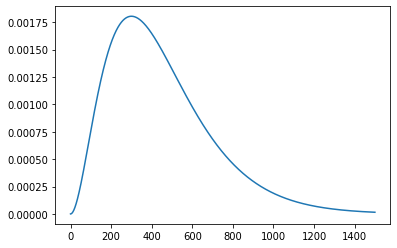

In [58]:
import matplotlib.pyplot as plt
from scipy.stats import gamma
alpha = 1.65
x = np.arange(0, 1500, 0.1)
y = gamma.pdf(x, 3, scale=150)
plt.plot(x, y)

In [60]:
# loc函数取targetUser==1的用户的id
targetUsers = dfUser.loc[dfUser['targetUser'] == 1, ['id']]

# 关联二度好友
df1 = pd.merge(targetUsers, dfRel, left_on=['id'], right_on=['userID'])
df2 = pd.merge(df1, dfRel, left_on=['friendID'], right_on=['userID'])
# 用group by计算共同好友数，形成分层索引；通过reset_index将series转为dataframe
# df3 = df2.groupby(['id','friendID_y'])['friendID_x'].count().reset_index()
friendNum = dfRel.groupby(['userID'])['friendID'].count().reset_index()
friendNum.rename(columns={'friendID':'friendNum'}, inplace=True)
df3 = pd.merge(df2, friendNum, left_on='friendID_x', right_on='userID')
df3.drop(columns=['userID_x', 'userID_y','userID'],inplace = True)
# 将结算结果改名为userID, ffID, CN
df3.rename(columns={'id':'userID','friendID_y':'ffID','friendID_x':'CN_id','friendNum':'CN_friendNum'}, inplace=True)
# df3["AA_index"] = 1/df3["CN_friendNum"]*np.log(df3["CN_friendNum"])
df3["AA_index"] = gamma.pdf(df3["CN_friendNum"], 3, scale=150) #AA_index
df4 = df3.groupby(['userID','ffID'])['AA_index'].sum().reset_index()
# 关联好友表，用于标记二度好友是否为好友
df6 = pd.merge(df4, dfRel, how='left', left_on=['userID','ffID'], right_on=['userID','friendID'])
# 将标记改为0,1，并改名为isFriend，数据类型改为int
df6.loc[df6['friendID'].isnull(), ['friendID']]=0
df6.loc[df6['friendID']>0, ['friendID']]=1
df6.rename(columns={'friendID':'isFriend'}, inplace=True)
df6['isFriend']=df6['isFriend'].astype(int)
# 构造输出结果
team = 'wbc_try_is_fake'
batch = 11
df7 = df6.loc[df6['isFriend']==0, ['userID','ffID',"AA_index"]]
df7 = df7[df7['userID'] != df7['ffID']]

# 选出前10推荐
df7['rn']=df7.groupby('userID')['AA_index'].rank(ascending=False, method='first')
df7.loc[df7['rn']<=15].to_csv("main.csv",index = None)
df7=df7.loc[df7['rn']<=10]
df7.insert(0,'teamID',team)
df7.insert(1,'batch',batch)
df7.rename(columns={'AA_index':'sIndex'},inplace=True)

In [52]:
df7

,teamID,batch,userID,ffID,sIndex,rn
340,wbc_try_is_fake,10,87702431,167729505,0.013834,1.0
349,wbc_try_is_fake,10,87702431,168921263,0.010862,7.0
601,wbc_try_is_fake,10,87702431,229525517,0.010151,9.0
2902,wbc_try_is_fake,10,87702431,561054567,0.009857,10.0
3013,wbc_try_is_fake,10,87702431,565648357,0.011241,5.0
...,...,...,...,...,...,...
1205402,wbc_try_is_fake,10,3195846773,548166323,0.000208,10.0
1205461,wbc_try_is_fake,10,3195846773,568855531,0.000236,8.0
1205500,wbc_try_is_fake,10,3195846773,585999285,0.000285,6.0
1205555,wbc_try_is_fake,10,3195846773,643975677,0.000279,7.0


In [ ]:
# # loc函数取targetUser==1的用户的id
# targetUsers = dfUser.loc[dfUser['targetUser'] == 1, ['id']]

# # 关联二度好友
# df1 = pd.merge(targetUsers, dfRel, left_on=['id'], right_on=['userID'])
# df2 = pd.merge(df1, dfRel, left_on=['friendID'], right_on=['userID'])
# # 用group by计算共同好友数，形成分层索引；通过reset_index将series转为dataframe
# # df3 = df2.groupby(['id','friendID_y'])['friendID_x'].count().reset_index()
# friendNum = dfRel.groupby(['userID'])['friendID'].count().reset_index()
# friendNum.rename(columns={'friendID':'friendNum'}, inplace=True)
# df3 = pd.merge(df2, friendNum, left_on='friendID_x', right_on='userID')
# df3.drop(columns=['friendID_x', 'friendID_y','userID'],inplace = True)
# # 将结算结果改名为userID, ffID, CN
# df3.rename(columns={'id':'userID','friendID_y':'ffID','friendID_x':'CN_id','friendNum':'CN_friendNum'}, inplace=True)

# # 补充用户信息
# df4 = pd.merge(df3, dfUser, left_on='userID', right_on='id')
# df5 = pd.merge(df4, dfUser, left_on='ffID', right_on='id')

# # 关联好友表，用于标记二度好友是否为好友
# df6 = pd.merge(df5, dfRel, how='left', left_on=['userID','ffID'], right_on=['userID','friendID'])
# # 将标记改为0,1，并改名为isFriend，数据类型改为int
# df6.loc[df6['friendID'].isnull(), ['friendID']]=0
# df6.loc[df6['friendID']>0, ['friendID']]=1
# df6.rename(columns={'friendID':'isFriend'}, inplace=True)
# df6['isFriend']=df6['isFriend'].astype(int)
# # 计算指标
# df6['s_Salton']=df6['CN']/df6['nFriends_x']*df6['nFriends_y']
# # print(df6.loc[df6['isFriend']>0].info())
# # 构造输出结果
# team = 'naive_benchmark'
# team = 'try_1'
# batch = 1
# df7 = df6.loc[df6['isFriend']==0, ['userID','ffID','s_Salton']]


In [ ]:
df7[df7["AA_index"]==np.inf]

In [ ]:
from sqlalchemy.types import VARCHAR,DECIMAL
def setdtypedict(df):
    dtypedict = {}
    for i, j in zip(df.columns, df.dtypes):
        if "object" in str(j):
            dtypedict.update({i:VARCHAR(256)})
        if "float" in str(j):
            dtypedict.update({i:DECIMAL(19, 2)})
        if "int" in str(j):
            dtypedict.update({i:DECIMAL(19)})
    return dtypedict

d_type=setdtypedict(df7)
df7.to_sql('Results', engine, index=False, if_exists='append', dtype=d_type, chunksize=1000)

# 机器学习

In [1]:
import pandas as pd
import numpy as np

# 读取本地csv文件到dataframe
dfUser = pd.read_csv("data/user.csv")
dfRel = pd.read_csv("data/relation.csv")
dfTruth = pd.read_csv("data/truth.csv")
# dfX = pd.read_csv("X_matrix.csv")
friendNum = dfRel.groupby(['userID'])['friendID'].count().reset_index()
friendNum_dic = dict(zip(friendNum['userID'],friendNum['friendID']))

In [7]:
dfUser[dfUser["nFriends"].notna()]["nFriends"].values

array([433., 663.,  59., ..., 473., 225., 229.])

In [9]:
np.median(dfUser[dfUser["nFriends"].notna()]["nFriends"].values)

561.0

In [10]:
np.average(dfUser[dfUser["nFriends"].notna()]["nFriends"].values)

726.914331417738

In [12]:
a = dfUser[dfUser["nFriends"].notna()]["nFriends"]

In [21]:
len(a[a<=10])

412

## 1. 构建样本

In [ ]:
#-*- coding:utf-8 -*-
import random
dfRel["is_friend"] = 1
# 概率入样
target_num = 1926400 #样本数量
user_list = list(dfUser["id"].values)
n = int(target_num/len(user_list))
for userID in user_list:
    not_friends = list(dfUser["id"].values)
    friend_list = list(dfRel[dfRel["userID"]==userID]["friendID"].values)
    friend_list.append(userID)
    for i in friend_list:
        try:
            not_friends.remove(i)
        except:
            print(userID,i)
    sample_list = random.sample(not_friends, n)
    temp = pd.DataFrame(sample_list,columns = ["friendID"])
    temp["userID"] = userID
    temp["is_friend"] = 0
    dfRel = pd.concat([dfRel, temp], ignore_index=True)

In [ ]:
data = pd.merge(dfRel,dfUser, left_on=['userID'], right_on=['id'])
data = pd.merge(data,dfUser, left_on=['friendID'], right_on=['id'])
data["fName"] = (data["fName_x"]==data["fName_y"])
data["homeProvince"] = (data["homeProvince_x"]==data["homeProvince_y"])
data["homeCity"] = (data["homeCity_x"]==data["homeCity_y"])
data["location"] = (data["location_x"]==data["location_y"])
data["privacy_mixture"] = data["privacy_x"]*data["privacy_y"]
data["gender"] = (data["gender_x"]==data["gender_y"])
data["nVisits_mixture"] = data["nVisits_x"]*data["nVisits_y"]
data["nShortPosts_mixture"] = data["nShortPosts_x"]*data["nShortPosts_y"]
data["nAlbums_mixture"] = data["nAlbums_x"]*data["nAlbums_y"]
data["nShares_mixture"] = data["nShares_x"]*data["nShares_y"]
data["nPosts_mixture"] = data["nPosts_x"]*data["nPosts_y"]
data["nLike_mixture"] = data["nLike_x"]*data["nLike_y"]
data["mobileUser"] = (data["mobileUser_x"]==data["mobileUser_y"])
data["starUser_mixture"] = (data["starUser_x"]*data["starUser_y"])
data.drop(columns = ['id_x', 'targetUser_x', 'fName_x', 'gender_x','starUser_x', 'mobileUser_x', 'homeProvince_x', 'homeCity_x','nFriends_x', 'nLike_x', 'nPosts_x', 'nShares_x', 'nAlbums_x','nShortPosts_x', 'nVisits_x', 'location_x', 'privacy_x', 'timeline_x','id_y', 'targetUser_y', 'fName_y', 'gender_y', 'starUser_y','mobileUser_y', 'homeProvince_y', 'homeCity_y', 'nFriends_y', 'nLike_y','nPosts_y', 'nShares_y', 'nAlbums_y', 'nShortPosts_y', 'nVisits_y','location_y', 'privacy_y', 'timeline_y'],inplace = True)
data.to_csv("X_matrix.csv",index=None)

## 构建AAindex

In [ ]:
import pandas as pd
dfUser = pd.read_csv("data/user.csv")
dfRel = pd.read_csv("data/relation.csv")
dfTruth = pd.read_csv("data/truth.csv")
dfX = pd.read_csv("result.csv")
friendNum = dfRel.groupby(['userID'])['friendID'].count().reset_index()
friendNum_dic = dict(zip(friendNum['userID'],friendNum['friendID']))
user_list = dfX.loc[:,"userID":"friendID"]

In [ ]:
Rel_matrix = pd.merge(dfRel, dfRel, left_on=['friendID'], right_on=['userID'])
Rel_matrix = pd.merge(Rel_matrix, friendNum, left_on='friendID_x', right_on='userID')

In [ ]:
# Rel_matrix = pd.merge(Rel_matrix,user_list, left_on=['userID',"ffID"], right_on=["userID","friendID"],how = "inner")

In [ ]:
Rel_matrix

In [ ]:
# Rel_matrix.drop(columns=['userID_y','userID'],inplace = True)
# 将结算结果改名为userID, ffID, CN
# Rel_matrix.rename(columns={'userID_x':'userID','friendID_y':'ffID','friendID_x':'CN_id','friendID':'CN_friendNum'}, inplace=True)
Rel_matrix["AA_index"] = 1/Rel_matrix["friendID"]*np.log(Rel_matrix["friendID"])
Rel_matrix = Rel_matrix.groupby(['userID_x','friendID_y'])['AA_index'].sum().reset_index()
Rel_matrix.rename(columns={'userID_x':'userID','friendID_y':'ffID'}, inplace=True)
Rel_matrix.to_csv("AA_index.csv",index = None)
dfX = pd.merge(dfX, Rel_matrix, left_on=["userID","friendID"], right_on=["userID","ffID"],how = "left")
dfX.to_csv("result.csv",index = None)

In [ ]:
dfX[dfX["AA_index"].notna()]["is_friend"].value_counts()

# 构建新X

In [ ]:
import pandas as pd
df_ffRel = pd.read_csv("AA_index.csv")
dfRel = pd.read_csv("data/relation.csv")
dfRel["is_friend"] = 1
df_ffRel = pd.merge(df_ffRel,dfRel, left_on=["userID","ffID"], right_on=["userID","friendID"],how = "left")
df_ffRel.loc[df_ffRel["is_friend"].isna(),"is_friend"] = 0
# df_ffRel.sample()
df_ffRel.drop(columns = ["friendID"],inplace = True)

In [ ]:
a = df_ffRel[df_ffRel["is_friend"] == 0].sample(1900000,ignore_index=True)
b = df_ffRel[df_ffRel["is_friend"] == 1]
data = pd.concat([a,b])

In [ ]:
dfUser = pd.read_csv("data/user.csv")
targetUsers = dfUser.loc[dfUser['targetUser'] == 1, ['id']].values.reshape(-1).tolist()
def is_target_user(x):
    if x in targetUsers:
        return True
    else:
        return False
data["is_target_user"] = data["userID"].apply(lambda x: is_target_user(x))
df_ffRel = data[data["is_target_user"] == False]
df_ffRel = df_ffRel.drop(columns=["is_target_user"])

In [ ]:
data = pd.merge(df_ffRel,dfUser, left_on=['userID'], right_on=['id'])
data = pd.merge(data,dfUser, left_on=['ffID'], right_on=['id'])
data["fName"] = (data["fName_x"]==data["fName_y"])
data["homeProvince"] = (data["homeProvince_x"]==data["homeProvince_y"])
data["homeCity"] = (data["homeCity_x"]==data["homeCity_y"])
data["location"] = (data["location_x"]==data["location_y"])
data["privacy_mixture"] = data["privacy_x"]*data["privacy_y"]
data["gender"] = (data["gender_x"]==data["gender_y"])
data["nVisits_mixture"] = data["nVisits_x"]*data["nVisits_y"]
data["nShortPosts_mixture"] = data["nShortPosts_x"]*data["nShortPosts_y"]
data["nAlbums_mixture"] = data["nAlbums_x"]*data["nAlbums_y"]
data["nShares_mixture"] = data["nShares_x"]*data["nShares_y"]
data["nPosts_mixture"] = data["nPosts_x"]*data["nPosts_y"]
data["nLike_mixture"] = data["nLike_x"]*data["nLike_y"]
data["mobileUser"] = (data["mobileUser_x"]==data["mobileUser_y"])
data["starUser_mixture"] = (data["starUser_x"]*data["starUser_y"])
data.drop(columns = ['id_x', 'fName_x', 'gender_x','starUser_x', 'mobileUser_x', 'homeProvince_x', 'homeCity_x','nFriends_x', 'nLike_x', 'nPosts_x', 'nShares_x', 'nAlbums_x','nShortPosts_x', 'nVisits_x', 'location_x', 'privacy_x', 'timeline_x','id_y', 'fName_y', 'gender_y', 'starUser_y','mobileUser_y', 'homeProvince_y', 'homeCity_y', 'nFriends_y', 'nLike_y','nPosts_y', 'nShares_y', 'nAlbums_y', 'nShortPosts_y', 'nVisits_y','location_y', 'privacy_y', 'timeline_y'],inplace = True)
data.to_csv("X_matrix.csv",index=None)

## 构建预测目标样本

In [ ]:
# loc函数取targetUser==1的用户的id
targetUsers = dfUser.loc[dfUser['targetUser'] == 1, ['id']]

# 关联二度好友
df1 = pd.merge(targetUsers, dfRel, left_on=['id'], right_on=['userID'])
df2 = pd.merge(df1, dfRel, left_on=['friendID'], right_on=['userID'])
# 用group by计算共同好友数，形成分层索引；通过reset_index将series转为dataframe
# df3 = df2.groupby(['id','friendID_y'])['friendID_x'].count().reset_index()
friendNum = dfRel.groupby(['userID'])['friendID'].count().reset_index()
friendNum.rename(columns={'friendID':'friendNum'}, inplace=True)
df3 = pd.merge(df2, friendNum, left_on='friendID_x', right_on='userID')
df3.drop(columns=['userID_x', 'userID_y','userID'],inplace = True)
# 将结算结果改名为userID, ffID, CN
df3.rename(columns={'id':'userID','friendID_y':'ffID','friendID_x':'CN_id','friendNum':'CN_friendNum'}, inplace=True)
df3["AA_index"] = 1/df3["CN_friendNum"]*np.log(df3["CN_friendNum"])
df4 = df3.groupby(['userID','ffID'])['AA_index'].sum().reset_index()
# 关联好友表，用于标记二度好友是否为好友
df6 = pd.merge(df4, dfRel, how='left', left_on=['userID','ffID'], right_on=['userID','friendID'])
# 将标记改为0,1，并改名为isFriend，数据类型改为int
df6.loc[df6['friendID'].isnull(), ['friendID']]=0
df6.loc[df6['friendID']>0, ['friendID']]=1
df6.rename(columns={'friendID':'isFriend'}, inplace=True)
df6['isFriend']=df6['isFriend'].astype(int)
# 构造输出结果
team = 'naive_benchmark'
batch = 5
df7 = df6.loc[df6['isFriend']==0, ['userID','ffID',"AA_index"]]
df7 = df7[df7['userID'] != df7['ffID']]

In [ ]:
data = pd.merge(df7,dfUser, left_on=['userID'], right_on=['id'])
data = pd.merge(data,dfUser, left_on=['ffID'], right_on=['id'])
data["fName"] = (data["fName_x"]==data["fName_y"])
data["homeProvince"] = (data["homeProvince_x"]==data["homeProvince_y"])
data["homeCity"] = (data["homeCity_x"]==data["homeCity_y"])
data["location"] = (data["location_x"]==data["location_y"])
data["privacy_mixture"] = data["privacy_x"]*data["privacy_y"]
data["gender"] = (data["gender_x"]==data["gender_y"])
data["nVisits_mixture"] = data["nVisits_x"]*data["nVisits_y"]
data["nShortPosts_mixture"] = data["nShortPosts_x"]*data["nShortPosts_y"]
data["nAlbums_mixture"] = data["nAlbums_x"]*data["nAlbums_y"]
data["nShares_mixture"] = data["nShares_x"]*data["nShares_y"]
data["nPosts_mixture"] = data["nPosts_x"]*data["nPosts_y"]
data["nLike_mixture"] = data["nLike_x"]*data["nLike_y"]
data["mobileUser"] = (data["mobileUser_x"]==data["mobileUser_y"])
data["starUser_mixture"] = (data["starUser_x"]*data["starUser_y"])
data.drop(columns = ['id_x', 'targetUser_x', 'fName_x', 'gender_x','starUser_x', 'mobileUser_x', 'homeProvince_x', 'homeCity_x','nFriends_x', 'nLike_x', 'nPosts_x', 'nShares_x', 'nAlbums_x','nShortPosts_x', 'nVisits_x', 'location_x', 'privacy_x', 'timeline_x','id_y', 'targetUser_y', 'fName_y', 'gender_y', 'starUser_y','mobileUser_y', 'homeProvince_y', 'homeCity_y', 'nFriends_y', 'nLike_y','nPosts_y', 'nShares_y', 'nAlbums_y', 'nShortPosts_y', 'nVisits_y','location_y', 'privacy_y', 'timeline_y'],inplace = True)
data.to_csv("target_matrix.csv",index=None)

## 数据预处理

In [3]:
df = pd.read_csv("data/result_6.csv")
df2 = pd.read_csv("main.csv")

In [4]:
team = 'wbc_try_is_fake'
batch = 3
df7 = df[df['userID'] != df['ffID']]

# 选出前10推荐
df7['rn']=df7.groupby('userID')["is_friend_prob"].rank(ascending=False, method='first')
df2 = df2[df2['userID'] != df2['ffID']]

In [5]:
# df7=df7.loc[df7['rn']<=10,["userID","ffID","is_friend_prob","rn"]]
# df7.insert(0,'teamID',team)
# df7.insert(1,'batch',batch)
# df7.rename(columns={"is_friend_prob":'sIndex'},inplace=True)

In [29]:
df8=df7.loc[df7['rn']<=5,["userID","ffID","is_friend_prob","rn"]]
df8.rename(columns={"is_friend_prob":'sIndex'},inplace=True)

In [30]:
data = pd.merge(df2, df8, left_on=["userID","ffID"], right_on=["userID","ffID"],how = "left")
data["rn2"] = data[data["rn_y"].isna()].groupby('userID')["AA_index"].rank(ascending=False, method='first')
df9=data.loc[data['rn2']<=5]
df9["rn"] = df9["rn2"]+5
df9 = df9.loc[:,["userID","AA_index","ffID","rn"]]
df9.rename(columns={"AA_index":'sIndex'},inplace=True)

c:\Users\zjchenb139\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [31]:
df10 = pd.concat([df8,df9])
df10.insert(0,'teamID',team)
df10.insert(1,'batch',batch)

In [61]:
from sqlalchemy.types import VARCHAR,DECIMAL
def setdtypedict(df):
    dtypedict = {}
    for i, j in zip(df.columns, df.dtypes):
        if "object" in str(j):
            dtypedict.update({i:VARCHAR(256)})
        if "float" in str(j):
            dtypedict.update({i:DECIMAL(19, 2)})
        if "int" in str(j):
            dtypedict.update({i:DECIMAL(19)})
    return dtypedict

d_type=setdtypedict(df7)
df7.to_sql('Results', engine, index=False, if_exists='append', dtype=d_type, chunksize=1000)

In [62]:
# 打印结果表单
sql = "select * from scoreSheetA"
a = pd.read_sql(sql, connect).sort_values(by=['pScore'],ascending=False)

In [63]:
a

,teamID,batch,pAT5,pAT10,pScore
339,emm,15,0.83,0.735,0.802
85,emm,14,0.83,0.735,0.802
322,emmemm,9,0.83,0.735,0.802
126,对不起这真的是个意外,9,0.83,0.735,0.802
252,emm,16,0.83,0.735,0.802
...,...,...,...,...,...
149,听我说谢谢你,3,0.00,0.000,0.000
210,test-1,4,0.00,0.000,0.000
163,111111,3,0.00,0.000,0.000
202,听我说谢谢你,2,0.00,0.000,0.000


In [64]:
a[a["teamID"] == "wbc_try_is_fake"]

,teamID,batch,pAT5,pAT10,pScore
231,wbc_try_is_fake,3,0.82,0.750,0.799
232,wbc_try_is_fake,6,0.82,0.750,0.799
125,wbc_try_is_fake,2,0.80,0.755,0.787
4,wbc_try_is_fake,5,0.82,0.625,0.762
103,wbc_try_is_fake,1,0.80,0.400,0.680
5,wbc_try_is_fake,11,0.56,0.455,0.529
104,wbc_try_is_fake,10,0.49,0.360,0.451


In [ ]:
# 关闭数据库连接
engine.dispose
cursor.close()   
connect.close()